In [12]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Paths
data_dir = 'C:/Users/louay/Desktop/Cats_and_Dogs/all_data'
output_dir = 'C:/Users/louay/Desktop/Cats_and_Dogs'

# Create output directories
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')

for folder in [train_dir, val_dir, test_dir]:
    os.makedirs(os.path.join(folder, 'cats'), exist_ok=True)
    os.makedirs(os.path.join(folder, 'dogs'), exist_ok=True)

# Parameters for splitting
train_ratio = 0.8
val_ratio = 0.15
test_ratio = 0.05

# Gather all image paths
cats = [os.path.join(data_dir, 'cats', f) for f in os.listdir(os.path.join(data_dir, 'cats')) if f.endswith('.jpg')]
dogs = [os.path.join(data_dir, 'dogs', f) for f in os.listdir(os.path.join(data_dir, 'dogs')) if f.endswith('.jpg')]

# Split into train, val, and test
def split_data(filepaths, train_ratio, val_ratio):
    train_files, temp_files = train_test_split(filepaths, train_size=train_ratio, random_state=42)
    val_files, test_files = train_test_split(temp_files, train_size=val_ratio / (val_ratio + test_ratio), random_state=42)
    return train_files, val_files, test_files

cats_train, cats_val, cats_test = split_data(cats, train_ratio, val_ratio)
dogs_train, dogs_val, dogs_test = split_data(dogs, train_ratio, val_ratio)

# Function to copy files to respective directories
def copy_files(filepaths, target_dir):
    for filepath in filepaths:
        shutil.copy(filepath, target_dir)

# Copy files
copy_files(cats_train, os.path.join(train_dir, 'cats'))
copy_files(cats_val, os.path.join(val_dir, 'cats'))
copy_files(cats_test, os.path.join(test_dir, 'cats'))

copy_files(dogs_train, os.path.join(train_dir, 'dogs'))
copy_files(dogs_val, os.path.join(val_dir, 'dogs'))
copy_files(dogs_test, os.path.join(test_dir, 'dogs'))

print("Data successfully split and copied!")


Data successfully split and copied!


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
import torch.optim.lr_scheduler as lr_scheduler

In [2]:
# Dataset paths
train_dir = 'C:/Users/louay/Desktop/Cats_and_Dogs/train'
val_dir = 'C:/Users/louay/Desktop/Cats_and_Dogs/val'
test_dir = 'C:/Users/louay/Desktop/Cats_and_Dogs/test'

# Parameters
batch_size = 16
num_epochs = 10
learning_rate = 0.0001
img_size = 224  # Vision Transformers typically expect 224x224 images
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transformations with augmentation for training
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation and Test transformations
val_test_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Datasets
train_dataset = ImageFolder(train_dir, transform=train_transform)
val_dataset = ImageFolder(val_dir, transform=val_test_transform)
test_dataset = ImageFolder(test_dir, transform=val_test_transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [3]:
# Load the pre-trained Vision Transformer model
model = models.vit_b_16(pretrained=True)

# Freeze the weights of the pre-trained model
for param in model.parameters():
    param.requires_grad = False

# Modify the model to add new dense layers
num_features = model.heads.head.in_features
model.heads.head = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 1)  # Binary classification
)

# Move the model to the GPU if available
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.heads.head.parameters(), lr=learning_rate)

c:\Users\louay\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\louay\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Function to evaluate the model
def evaluate_model(model, data_loader, criterion):
    model.eval()
    val_loss = 0.0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            val_preds.extend(torch.sigmoid(outputs).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_acc = accuracy_score((np.array(val_preds) > 0.5).astype(int), val_labels)
    return val_loss / len(data_loader), val_acc

# Function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_preds, train_labels = [], []

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_preds.extend(torch.sigmoid(outputs).cpu().detach().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_acc = accuracy_score((np.array(train_preds) > 0.5).astype(int), train_labels)
        val_loss, val_acc = evaluate_model(model, val_loader, criterion)

        history["train_loss"].append(train_loss / len(train_loader))
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss / len(train_loader):.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return history

# Train the model with the new dense layers
history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)


Epoch 1/10: 100%|██████████| 1250/1250 [17:04<00:00,  1.22it/s]


Epoch 1/10, Train Loss: 0.1008, Train Acc: 0.9708, Val Loss: 0.0292, Val Acc: 0.9928


Epoch 2/10: 100%|██████████| 1250/1250 [16:30<00:00,  1.26it/s]


Epoch 2/10, Train Loss: 0.0555, Train Acc: 0.9802, Val Loss: 0.0242, Val Acc: 0.9936


Epoch 3/10: 100%|██████████| 1250/1250 [16:33<00:00,  1.26it/s]


Epoch 3/10, Train Loss: 0.0524, Train Acc: 0.9794, Val Loss: 0.0218, Val Acc: 0.9944


Epoch 4/10: 100%|██████████| 1250/1250 [16:35<00:00,  1.26it/s]


Epoch 4/10, Train Loss: 0.0488, Train Acc: 0.9805, Val Loss: 0.0217, Val Acc: 0.9947


Epoch 5/10: 100%|██████████| 1250/1250 [16:38<00:00,  1.25it/s]


Epoch 5/10, Train Loss: 0.0497, Train Acc: 0.9802, Val Loss: 0.0203, Val Acc: 0.9949


Epoch 6/10: 100%|██████████| 1250/1250 [16:35<00:00,  1.26it/s]


Epoch 6/10, Train Loss: 0.0449, Train Acc: 0.9833, Val Loss: 0.0201, Val Acc: 0.9944


Epoch 7/10: 100%|██████████| 1250/1250 [16:34<00:00,  1.26it/s]


Epoch 7/10, Train Loss: 0.0459, Train Acc: 0.9825, Val Loss: 0.0195, Val Acc: 0.9944


Epoch 8/10: 100%|██████████| 1250/1250 [16:34<00:00,  1.26it/s]


Epoch 8/10, Train Loss: 0.0478, Train Acc: 0.9817, Val Loss: 0.0183, Val Acc: 0.9944


Epoch 9/10: 100%|██████████| 1250/1250 [16:32<00:00,  1.26it/s]


Epoch 9/10, Train Loss: 0.0460, Train Acc: 0.9814, Val Loss: 0.0187, Val Acc: 0.9941


Epoch 10/10:  56%|█████▌    | 701/1250 [09:19<07:20,  1.25it/s]

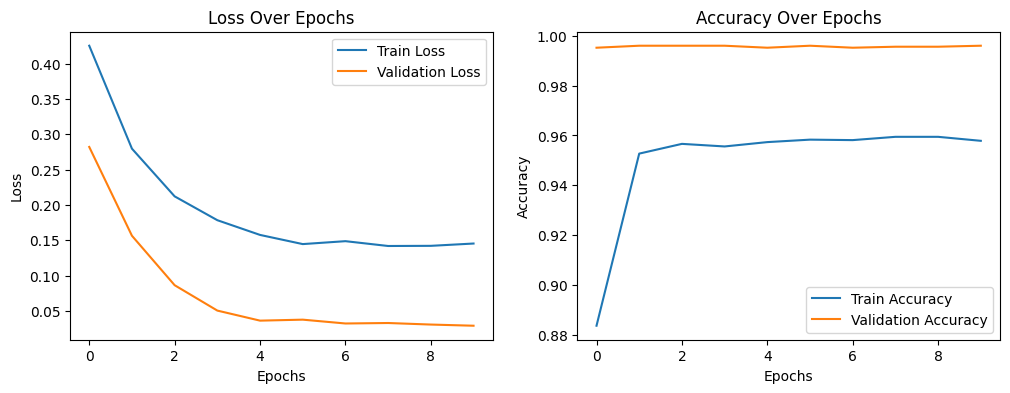

Test Loss: 0.0358, Test Accuracy: 0.9928, Precision: 0.9904, Recall: 0.9952, F1: 0.9928


In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.legend()

plt.show()

# Test the model
test_loss, test_acc = evaluate_model(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
